In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

In [2]:
# Read scrobbles imported using scrobbles_importer
dataset_path = './datasets/'
scrobbles_csv_file = 'lucas_scrobbles.csv'
scrobbles = pd.read_csv(dataset_path + scrobbles_csv_file,
                        delimiter=';',
                        names=['artist','song','date','time'])

# Merge date and time into timestamp and delete them
timestamp = pd.to_datetime(scrobbles['date'] + ', ' + scrobbles['time'])
scrobbles.insert(scrobbles.shape[1], 'timestamp', timestamp)
del scrobbles['date'], scrobbles['time']

Number of unique artists: 1878


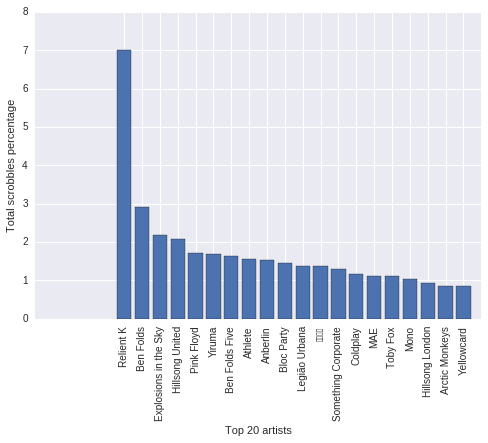

In [3]:
def plot_rank(scrobbles, top=10, relative=False, column='artist'):
    rank = scrobbles[column].value_counts()
    
    labels = rank[0:top].keys()
    values = rank[0:top]
    
    if relative:
        total = scrobbles.shape[0]
        values = (values/total)*100.0
        
    plt.figure()
    plt.bar(np.arange(0,top), values, align='center')
    plt.xticks(np.arange(0,top), labels,rotation=90)
    plt.xlabel('Top {} {}'.format(top, column + 's'))
    if relative:
        plt.ylabel('Total scrobbles percentage')
    else:
        plt.ylabel('Scrobbles count')
    

def number_of_unique_artists(scrobbles):
    return scrobbles['artist'].nunique()

print('Number of unique artists: {}'.format(number_of_unique_artists(scrobbles)))
plot_rank(scrobbles, relative=True, top=20, column='artist')

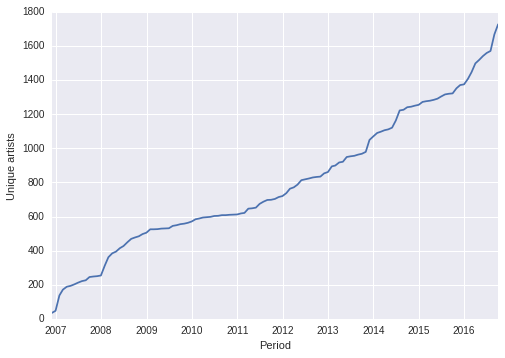

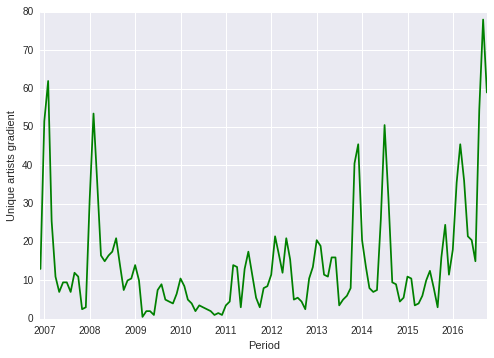

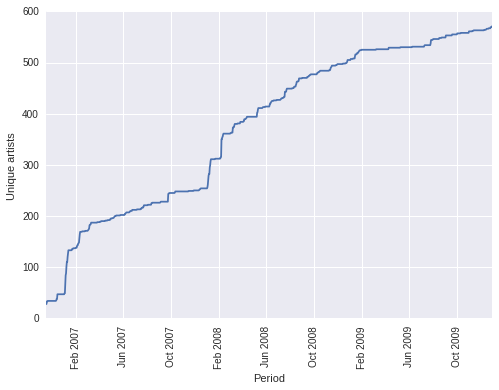

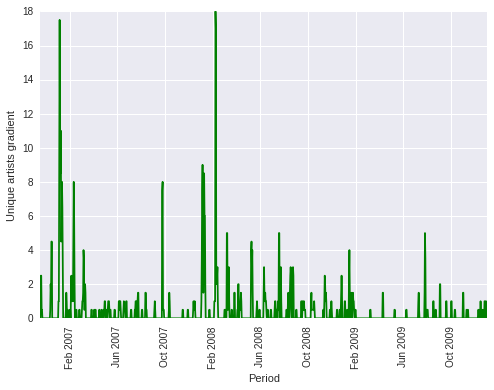

In [4]:
def plot_unique_artists_evolution(scrobbles, start=None, end=None, freq='1M', ticks_angle=None):
    if start is None:
        # Get first scrobble
        start = scrobbles['timestamp'].iloc[-1]

    if end is None:
        # Get last scrobble
        end = scrobbles['timestamp'].iloc[0]

    date_range = pd.date_range(start, end, freq=freq)

    nunique_artists = []
    for date in date_range:
        query = scrobbles[scrobbles['timestamp'] < date]
        nunique_artists.append(number_of_unique_artists(query))
    
    plt.figure()
    plt.plot(date_range, nunique_artists)
    plt.xlabel('Period')
    plt.ylabel('Unique artists')
    if ticks_angle is not None:
        plt.xticks(rotation=ticks_angle)

    plt.figure()
    plt.plot(date_range, np.gradient(nunique_artists), color='green')
    plt.xlabel('Period')
    plt.ylabel('Unique artists gradient')
    if ticks_angle is not None:
        plt.xticks(rotation=ticks_angle)

plot_unique_artists_evolution(scrobbles)
plot_unique_artists_evolution(scrobbles,end='2010',freq='1D', ticks_angle=90)

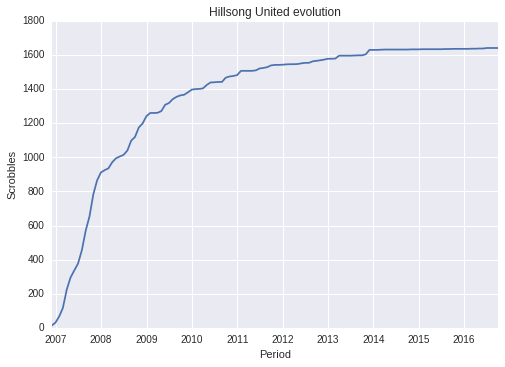

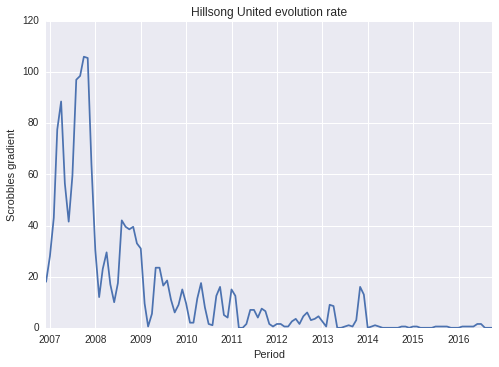

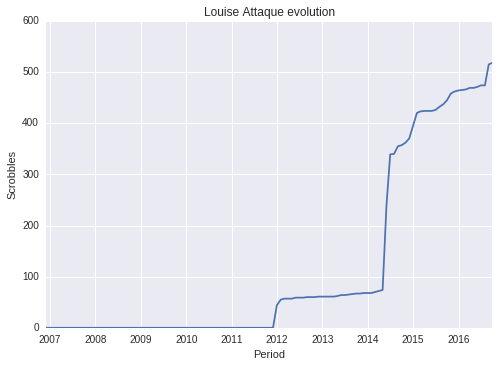

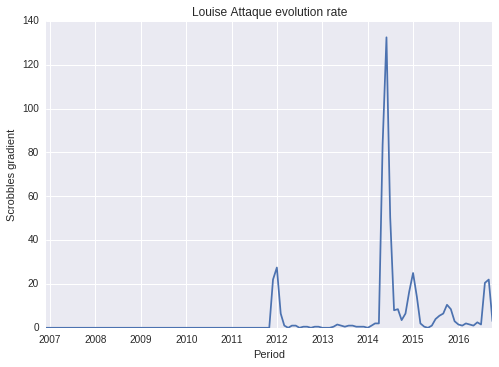

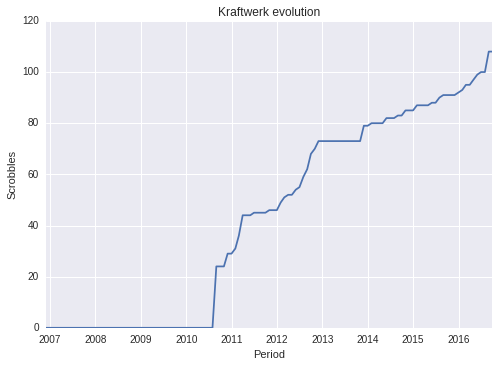

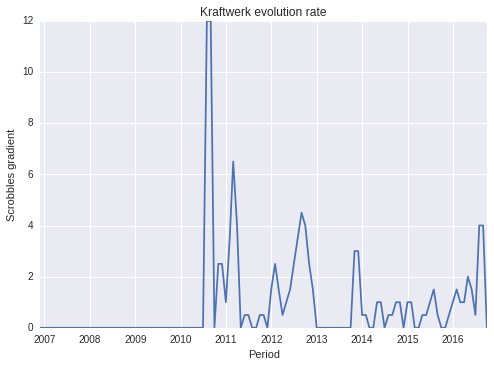

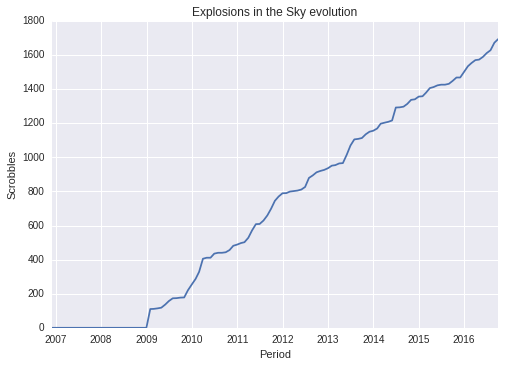

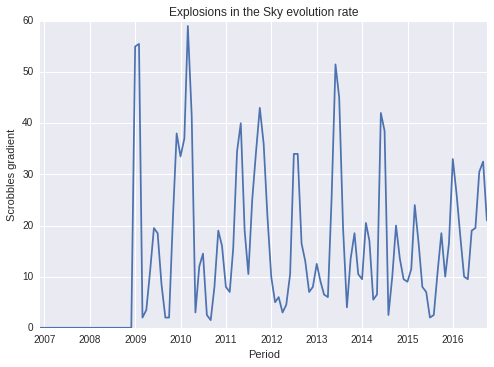

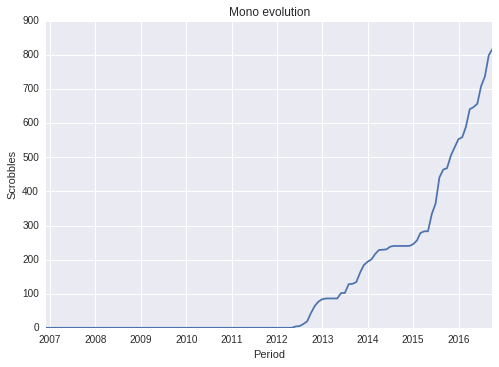

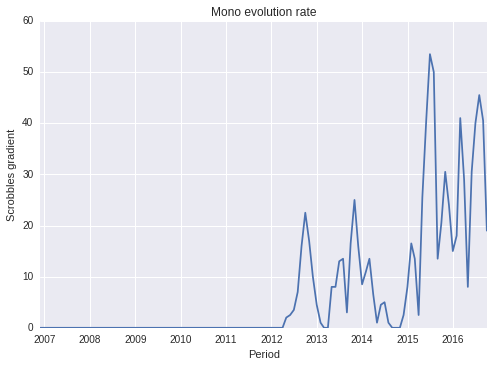

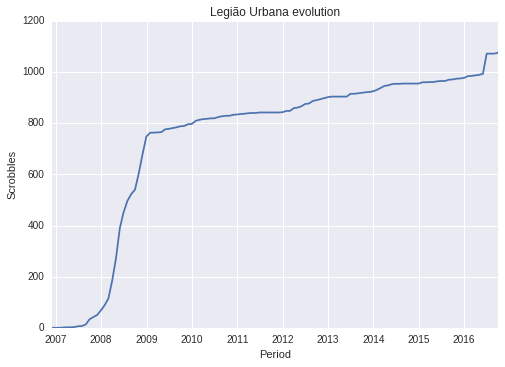

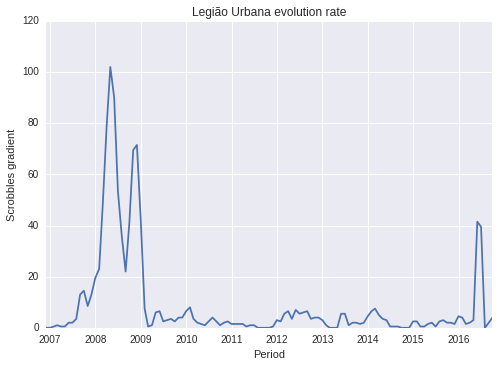

In [5]:
def plot_artist_evolution(scrobbles, artist, start=None, end=None, freq='1M', ticks_angle=None):
    
    if start is None:
        # Get first scrobble
        start = scrobbles['timestamp'].iloc[-1]

    if end is None:
        # Get last scrobble
        end = scrobbles['timestamp'].iloc[0]

    date_range = pd.date_range(start, end, freq=freq)

    scrobbles_number = []
    for date in date_range:
        query_artist = scrobbles[scrobbles['artist'] == artist]
        query_scrobbles = query_artist[query_artist['timestamp'] < date]
        scrobbles_number.append(query_scrobbles.shape[0])
    
    plt.figure()
    plt.plot(date_range, scrobbles_number)
    plt.xlabel('Period')
    plt.ylabel('Scrobbles')
    plt.title(artist +' evolution')
    if ticks_angle is not None:
        plt.xticks(rotation=ticks_angle)
        
    plt.figure()
    plt.plot(date_range, np.gradient(scrobbles_number))
    plt.xlabel('Period')
    plt.ylabel('Scrobbles gradient')
    plt.title(artist +' evolution rate')
    if ticks_angle is not None:
        plt.xticks(rotation=ticks_angle)   
        
plot_artist_evolution(scrobbles, 'Hillsong United')        
plot_artist_evolution(scrobbles, 'Louise Attaque')
plot_artist_evolution(scrobbles, 'Kraftwerk')
plot_artist_evolution(scrobbles, 'Explosions in the Sky')
plot_artist_evolution(scrobbles, 'Mono')
plot_artist_evolution(scrobbles, 'Legião Urbana')

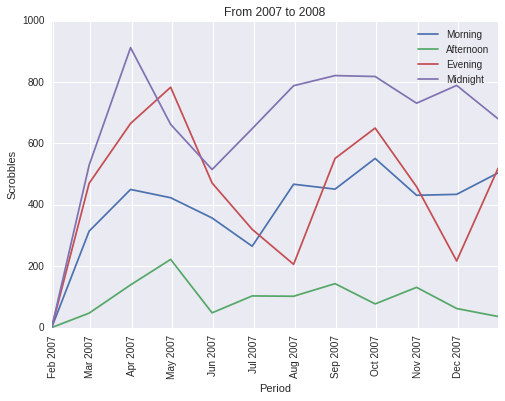

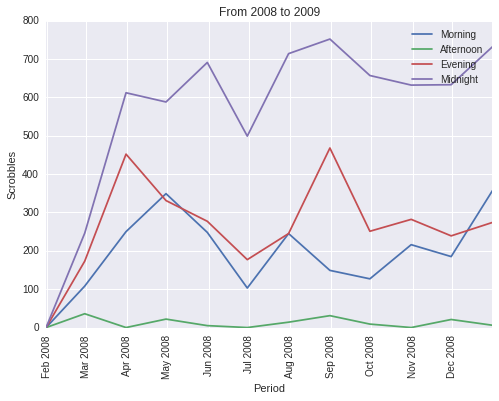

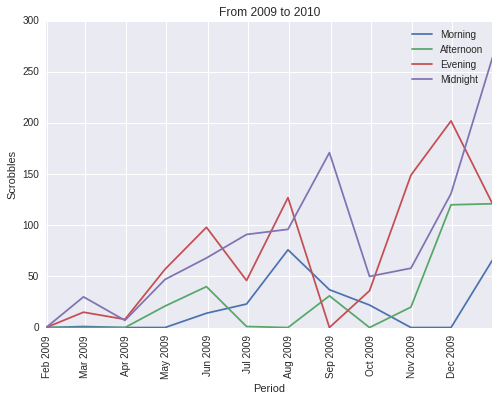

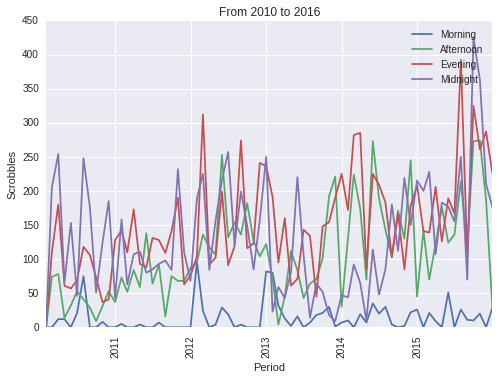

In [6]:
def timestamp_period(timestamp):
    time = timestamp.time()
    
    cond_midnight = time >= datetime.time(0,0) and time < datetime.time(6,0)
    cond_morning = time >= datetime.time(6,0) and time < datetime.time(12,0)
    cond_afternoon = time >= datetime.time(12,0) and time < datetime.time(18,0)
    cond_evening = time >= datetime.time(18,0) and time <= datetime.time(23,59)
    
    if cond_midnight:
        return 'Midnight'
    elif cond_morning:
        return 'Morning'
    elif cond_afternoon:
        return 'Afternoon'
    elif cond_evening:
        return 'Evening'
    
    
def plot_scrobbles_day_periods(scrobbles, start=None, end=None, freq='1M', ticks_angle=None):
    if start is None:
        # Get first scrobble
        start = scrobbles['timestamp'].iloc[-1]

    if end is None:
        # Get last scrobble
        end = scrobbles['timestamp'].iloc[0]  
        
    date_range = pd.date_range(start, end, freq=freq)
        
    # compute day period for each timestamp
    scrobbles_periods = scrobbles['timestamp'].apply(timestamp_period)
    pscrobbles = scrobbles.assign(period=scrobbles_periods)
    
    scrobbles_midnight = []
    scrobbles_morning = []
    scrobbles_afternoon = []
    scrobbles_evening = []

    for i in np.arange(0,len(date_range)):

        s = date_range[i-1]
        e = date_range[i]

        query1 = pscrobbles[ pscrobbles['timestamp'] < e ]
        query2 = query1[ query1['timestamp'] > s ]    

        pcounts = query2['period'].value_counts()
        if 'Evening' in pcounts:
            scrobbles_evening.append(pcounts['Evening'])
        else:
            scrobbles_evening.append(0)

        if 'Afternoon' in pcounts:
            scrobbles_afternoon.append(pcounts['Afternoon'])
        else:
            scrobbles_afternoon.append(0)        

        if 'Midnight' in pcounts:
            scrobbles_midnight.append(pcounts['Midnight'])
        else:
            scrobbles_midnight.append(0)        

        if 'Morning' in pcounts:
            scrobbles_morning.append(pcounts['Morning'])
        else:
            scrobbles_morning.append(0)        

    plt.figure()
    plt.plot(date_range, scrobbles_morning)
    plt.plot(date_range, scrobbles_afternoon)
    plt.plot(date_range, scrobbles_evening)
    plt.plot(date_range, scrobbles_midnight)
    plt.legend(['Morning','Afternoon','Evening','Midnight'])
    plt.xlabel('Period')
    plt.ylabel('Scrobbles')
    plt.title('From {} to {}'.format(start,end))
    if ticks_angle is not None:
        plt.xticks(rotation=ticks_angle)
        

plot_scrobbles_day_periods(scrobbles, start='2007',end='2008',ticks_angle=90)  
plot_scrobbles_day_periods(scrobbles, start='2008',end='2009',ticks_angle=90)        
plot_scrobbles_day_periods(scrobbles, start='2009',end='2010',ticks_angle=90)   
plot_scrobbles_day_periods(scrobbles, start='2010',end='2016',ticks_angle=90)   

In [7]:
def get_top_artists(scrobbles, start, end, top=10):

    qscrobbles = scrobbles[scrobbles['timestamp']<end]
    qscrobbles = qscrobbles[qscrobbles['timestamp']>start]
    
    artists_count = qscrobbles['artist'].value_counts()
    return artists_count.iloc[0:top].keys().values
    
get_top_artists(scrobbles,'2013/07','2014/07',top=10) # quand j'étais en France ...

array(['Louise Attaque', 'Os Paralamas Do Sucesso', 'Metronomy',
       'Explosions in the Sky', 'Relient K', 'Mono', 'Daft Punk',
       'Coldplay', 'Yellowcard', 'Natiruts'], dtype=object)